In [1]:
# version = "lattice"
# version = "gaugefields"
version = "gaugefields_betterBL"

### Run the Glasma code

Import packages

In [2]:
# Set environment variables 
import os
os.environ["MY_NUMBA_TARGET"] = "cuda"
os.environ["GAUGE_GROUP"] = "su3"
os.environ["PRECISION"] = "double"

# Import curraun 
import sys
sys.path.append('..')

import curraun.core as core
import curraun.mv as mv
if version=="lattice":
    from curraun.energy_update import Energy
else:
    from curraun.energy_update import Energy_GaugeFields as Energy
import curraun.initial as initial
initial.DEBUG = False

from curraun.numba_target import use_cuda, use_numba
if use_cuda:
    from numba import cuda

Using CUDA
Using SU(3)
Using double precision
Using double precision


---
### Simulation parameters
Chosen to match Pooja's, namely
- Gauge group SU(3)
- Nb. of color sheets $N_s=1$
- Nb. of lattice points $N=512$
- Transverse simulation length $L=2\,\mathrm{fm}$
- Leapfrog time step $1/8=0.125$
- Simulation time $\tau_\mathrm{stop}=0.4\,\mathrm{fm/}c$
- Saturation momentum $Q_s=3\,\mathrm{GeV}$
- Coupling constant $g=\sqrt{2\pi\alpha_s}$ with runnning coupling $\alpha_s=\dfrac{2\pi}{\dfrac{33-2 N_f}{3}}\dfrac{1}{\mathrm{log}\left(\dfrac{Q_s}{\lambda_{\mathrm{QCD}}}\right)}$
- Factor relating the MV model $g^2\mu$ to the saturation scale $Q_s=0.6 g^2\mu$ 

In [3]:
import numpy as np

# hbar * c [GeV * fm]
hbarc = 0.197326 

# Simulation box 
L = 2      
N = 512    
tau_sim = 0.4     
DTS = 8     

# Glasma fields
su_group = 'su3'
Qs = 3        
ns = 1    
factor = 0.6        
g2mu = Qs / factor     
g = np.pi * np.sqrt(1 / np.log(Qs / 0.2))          		
mu = g2mu / g**2          	
ir = 0.1 * g**2 * mu         
uv = 10.0       

nevents = 20

### Simulation routine for evolving the Glasma fields

In [4]:
import pickle
from tqdm import tqdm

# Simulation routine
def simulate(ev): 
    output = {}

    output["tau"] = []
    output["E"], output["B"] = [], [] 

    # Derived parameters
    a = L / N
    E0 = N / L * hbarc
    DT = 1.0 / DTS
    maxt = int(tau_sim / a) * DTS

    # Initialize Glasma fields
    s = core.Simulation(N, DT, g)
    va = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    vb = mv.wilson(s, mu=mu / E0, m=ir / E0, uv=uv / E0, num_sheets=ns)
    initial.init(s, va, vb)

    # Initialize energy computation
    en = Energy(s)

    if use_cuda:
        s.copy_to_device()


    with tqdm(total=maxt) as pbar:
        for t in range(maxt):            
            # Evolve Glasma fields
            core.evolve_leapfrog(s)

            if t>=1:
                # Energy density calculation
                en.compute()

                # [GeV^4]
                units_edcomp = E0 ** 4 
 
                output["E"].append(en.E_mean * units_edcomp)
                output["B"].append(en.B_mean * units_edcomp)

                output["tau"].append(t * a / DTS)


            pbar.set_description("Event " + str(ev+1))
            pbar.update(1)
    
    output["E"], output["B"] = np.array(output["E"]), np.array(output["B"])

    if use_cuda:
        cuda.current_context().deallocations.clear()

    return output

In [5]:
collect_E, collect_B = [], []

for ev in range(nevents):
    output = simulate(ev)

    collect_E.append(output["E"])
    collect_B.append(output["B"])

E_avg, B_avg = np.mean(np.array(collect_E), axis=0), np.mean(np.array(collect_B), axis=0)
E_std, B_std = np.std(np.array(collect_E), axis=0), np.std(np.array(collect_B), axis=0)
tau = output["tau"]

Event 20: 100%|██████████| 816/816 [00:30<00:00, 26.47it/s]


In [6]:
results = {}
results["tau"] = tau
results["E_avg"], results["B_avg"] = E_avg, B_avg
results["E_std"], results["B_std"] = E_std, B_std
# Useful unit conversion
results["E0"], results["hbarc"] = N / L * hbarc, hbarc

if version=="lattice":
    filename = 'results/ed_comp_gaugelinks.pickle'
elif version=="gaugefields":
    filename = 'results/ed_comp_gaugefields.pickle'
else:
    filename = 'results/ed_comp_gaugefields_betterBL.pickle'
with open(filename, 'wb') as handle:
    pickle.dump(results, handle)

---
### Read results from file

In [1]:
import pickle

results = pickle.load(open("ed_comp_gaugelinks.pickle", "rb"))

tau = results["tau"]
E_avg, B_avg = results["E_avg"], results["B_avg"]
E_std, B_std = results["E_std"], results["B_std"]
E0, hbarc = results["E0"], results["hbarc"]

### Pooja's energy density
Read XMGrace file in Python using [Python module to load xmgrace plots into numpy arrays
](https://gist.github.com/mlund/e8add748a9071b2ea983)

In [2]:
import numpy as np
import re

class LoadGrace:
  """
  Simple module to load a Grace file (.agr) plot and extract
  legends, comments, and -- importantly -- data into numpy arrays.
  """
  
  def __init__(self, filename):
    self._sets = []
    self._legends = []
    self._comments = []

    f = open(filename, 'r')
    for line in f:
      if re.compile('@    s(.*) legend').search(line):
        self._legends.append( line.split('"')[1] )

      if re.compile('@    s(.*) comment').search(line):
        self._comments.append( line.split('"')[1] )

      if '@target' in line:
        tmp = []
        next(f)
        for row in f:
          if row!='&\n':
            tmp.append( np.fromstring( row, sep=' ' ) )
          else:
            self._sets.append( np.array(tmp) )
            break
    f.close()

  def sets(self): return self._sets
  def legends(self): return self._legends
  def comments(self): return self._comments
  def __len__(self): return len(self._sets)

In [3]:
d =  LoadGrace("Energy_density.agr")

for i in range(0, len(d)):
    print('# legend=' + d.legends()[i] + ' comment=' + d.comments()[i])
    print(d.sets()[i])

# legend=\xe\f{}\sE\sx comment=/home/pooja45/Desktop/Research/6_SU(3)/Dana/Liu_SU3_Qs3_Server_2/fort.1001
[[4.8828125e-04 2.0165907e-02]
 [9.7656250e-04 5.0319575e-02]
 [1.4648438e-03 1.0034802e-01]
 ...
 [3.9892578e-01 6.9915177e-01]
 [3.9941406e-01 6.9828426e-01]
 [3.9990234e-01 6.9741977e-01]]
# legend=\xe\f{}\sE\sy comment=/home/pooja45/Desktop/Research/6_SU(3)/Dana/Liu_SU3_Qs3_Server_2/fort.1002
[[4.8828125e-04 2.0071435e-02]
 [9.7656250e-04 5.0083938e-02]
 [1.4648438e-03 9.9878403e-02]
 ...
 [3.9892578e-01 7.0329518e-01]
 [3.9941406e-01 7.0242757e-01]
 [3.9990234e-01 7.0155926e-01]]
# legend=\xe\f{}\sE\sz comment=/home/pooja45/Desktop/Research/6_SU(3)/Dana/Liu_SU3_Qs3_Server_2/fort.1003
[[4.8828125e-04 6.8417609e+01]
 [9.7656250e-04 6.8300254e+01]
 [1.4648438e-03 6.8105480e+01]
 ...
 [3.9892578e-01 1.3053423e+00]
 [3.9941406e-01 1.3035420e+00]
 [3.9990234e-01 1.3017477e+00]]
# legend=\xe\f{}\sB\sx comment=/home/pooja45/Desktop/Research/6_SU(3)/Dana/Liu_SU3_Qs3_Server_2/fort.1004


In [4]:
tau_p = d.sets()[1][:, 0]

E_p = np.transpose(np.array([d.sets()[i][:, 1] for i in [0, 1, 2]]))
B_p = np.transpose(np.array([d.sets()[i][:, 1] for i in [3, 4, 5]]))


In [26]:
from scipy import interpolate

ratios_E, ratios_B = [], []
for i in [0, 2]:
    if i==2:
        interp_map_E = interpolate.interp1d(tau_p, E_p[:, i])
        E_p_interp = interp_map_E(tau)
        ratios_E.append(E_avg[:, i]/E_p_interp)

        interp_map_B = interpolate.interp1d(tau_p, B_p[:, i])
        B_p_interp = interp_map_B(tau)
        ratios_B.append(B_avg[:, i]/B_p_interp)
    else:
        interp_map_E = interpolate.interp1d(tau_p, E_p[:, i]+E_p[:, i+1])
        E_p_interp = interp_map_E(tau)
        ratios_E.append((E_avg[:, i]+E_avg[:, i+1])/E_p_interp)

        interp_map_B = interpolate.interp1d(tau_p, B_p[:, i]+B_p[:, i+1])
        B_p_interp = interp_map_B(tau)
        ratios_B.append((B_avg[:, i]+B_avg[:, i+1])/B_p_interp)

/home/dana/anaconda3/envs/curraun/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


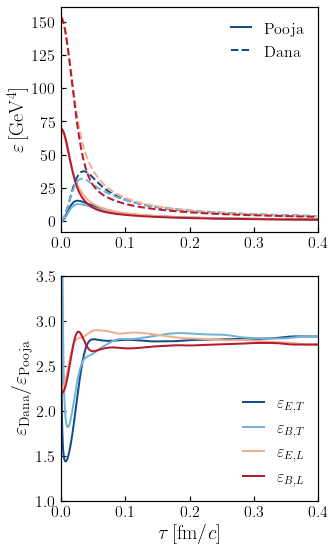

In [34]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (5, 8)

cmap_rb = mpl.cm.get_cmap('RdBu', 20)
colors = [cmap_rb(0.9), cmap_rb(0.7), cmap_rb(0.3), cmap_rb(0.1)]

fig, ax = plt.subplots(2, 1)

ax[0].plot(tau_p, (E_p[:, 0] + E_p[:, 1]), linewidth=2, color=colors[0])
ax[0].plot(tau_p, (B_p[:, 0] + B_p[:, 1]), linewidth=2, color=colors[1])

ax[0].plot(tau_p, E_p[:, 2], linewidth=2, color=colors[2])
ax[0].plot(tau_p, B_p[:, 2], linewidth=2, color=colors[3])

ax[0].plot(tau, E_avg[:, 0] + E_avg[:, 1], linewidth=2, color=colors[0], linestyle='--')
ax[0].plot(tau, B_avg[:, 0] + B_avg[:, 1], linewidth=2, color=colors[1], linestyle='--')

ax[0].plot(tau, E_avg[:, 2], linewidth=2, color=colors[2], linestyle='--')
ax[0].plot(tau, B_avg[:, 2], linewidth=2, color=colors[3], linestyle='--')

ax[1].plot(tau, ratios_E[0], linewidth=2, color=colors[0])
ax[1].plot(tau, ratios_B[0], linewidth=2, color=colors[1])

ax[1].plot(tau, ratios_E[1], linewidth=2, color=colors[2])
ax[1].plot(tau, ratios_B[1], linewidth=2, color=colors[3])

for i in range(2):
    ax[i].set_xlim(0, 0.4)
ax[1].set_ylim(1, 3.5)

# legends
handles, labels = ax[1].get_legend_handles_labels()
ed_labels = [r'$\varepsilon_{E, T}$', r'$\varepsilon_{B, T}$', r'$\varepsilon_{E, L}$', r'$\varepsilon_{B, L}$']
ed_lines = []
for ic, icolor in enumerate(colors):
    line = Line2D([0], [0], label=ed_labels[ic], color=colors[ic], linewidth=2)
    ed_lines.append(line)

handles.extend(ed_lines)
ax[1].legend(handles=handles, fontsize=16, loc='lower right')

handles, labels = ax[0].get_legend_handles_labels()
line_dana = Line2D([0], [0], label=r'$\mathrm{Dana}$', linestyle='--', color=colors[0], linewidth=2)
line_pooja = Line2D([0], [0], label=r'$\mathrm{Pooja}$', color=colors[0], linewidth=2)
handles.extend([line_pooja, line_dana])
ax[0].legend(handles=handles, fontsize=16, loc='upper right')

ax[1].set_xlabel(r'$\tau\,\mathrm{[fm/}c\mathrm{]}$')
ax[0].set_ylabel(r'$\varepsilon\,\mathrm{[GeV^4]}$')
ax[1].set_ylabel(r'$\varepsilon_{\mathrm{Dana}}/\varepsilon_{\mathrm{Pooja}}$')

plt.tight_layout()
plt.savefig('ed_comp_pooja_vs_dana.pdf', format='pdf')

---
### Extract energy density components from the gauge fields

In [23]:
import pickle

results = {}
results["links"] = pickle.load(open("ed_comp_gaugelinks.pickle", "rb"))
# results["potentials"] = pickle.load(open("ed_comp_gaugefields.pickle", "rb"))
results["potentials"] = pickle.load(open("ed_comp_gaugefields_betterBL.pickle", "rb"))

tau = {}
E_avg, B_avg = {}, {}
E_std, B_std = {}, {}

for version in ["links", "potentials"]:
    tau[version] = results[version]["tau"]
    E_avg[version], B_avg[version] = results[version]["E_avg"], results[version]["B_avg"]
    E_std[version], B_std[version] = results[version]["E_std"], results[version]["B_std"]

E0, hbarc = results["links"]["E0"], results["links"]["hbarc"]

/tmp/ipykernel_39779/1344705173.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap_rb = mpl.cm.get_cmap('RdBu', 20)


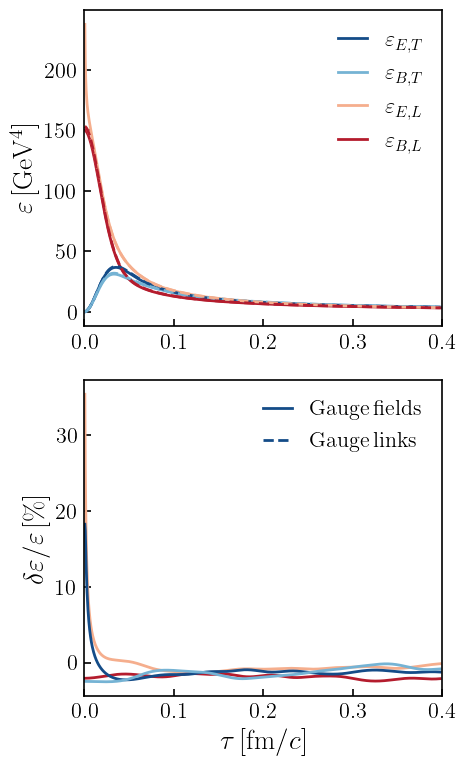

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.lines import Line2D

plt.style.use('nord_theme_light.mpltstyle')
plt.rcParams["figure.figsize"] = (5, 8)

cmap_rb = mpl.cm.get_cmap('RdBu', 20)
colors = [cmap_rb(0.9), cmap_rb(0.7), cmap_rb(0.3), cmap_rb(0.1)]

fig, ax = plt.subplots(2, 1)

linestyles = ['-', '--']

for (iv, version) in enumerate(["potentials", "links"]):
# for (iv, version) in enumerate(["links"]):

    ax[0].plot(tau[version], E_avg[version][:, 0] + E_avg[version][:, 1], linewidth=2, color=colors[0], linestyle=linestyles[iv])
    ax[0].plot(tau[version], B_avg[version][:, 0] + B_avg[version][:, 1], linewidth=2, color=colors[1], linestyle=linestyles[iv])

    ax[0].plot(tau[version], E_avg[version][:, 2], linewidth=2, color=colors[2], linestyle=linestyles[iv])
    ax[0].plot(tau[version], B_avg[version][:, 2], linewidth=2, color=colors[3], linestyle=linestyles[iv])

dif_EL = (E_avg["potentials"][:, 2]-E_avg["links"][:, 2])/E_avg["potentials"][:, 2]*100
dif_BL = (B_avg["potentials"][:, 2]-B_avg["links"][:, 2])/B_avg["potentials"][:, 2]*100
# dif_EL = (E_avg["potentials"][:, 2])/E_avg["links"][:, 2]
# dif_BL = (B_avg["potentials"][:, 2])/B_avg["links"][:, 2]
ax[1].plot(tau[version], dif_EL, linewidth=2, color=colors[2])
ax[1].plot(tau[version], dif_BL, linewidth=2, color=colors[3])

dif_ET = (E_avg["potentials"][:, 0]+E_avg["potentials"][:, 1]-E_avg["links"][:, 0]-E_avg["links"][:, 1])/(E_avg["potentials"][:, 0]+E_avg["potentials"][:, 1])*100
dif_BT = (B_avg["potentials"][:, 0]+B_avg["potentials"][:, 1]-B_avg["links"][:, 0]-B_avg["links"][:, 1])/(B_avg["potentials"][:, 0]+B_avg["potentials"][:, 1])*100
# dif_ET = (E_avg["potentials"][:, 0]+E_avg["potentials"][:, 1])/(E_avg["links"][:, 0]+E_avg["links"][:, 1])
# dif_BT = (B_avg["potentials"][:, 0]+B_avg["potentials"][:, 1])/(B_avg["links"][:, 0]+B_avg["links"][:, 1])
ax[1].plot(tau[version], dif_ET, linewidth=2, color=colors[0])
ax[1].plot(tau[version], dif_BT, linewidth=2, color=colors[1])

for i in range(2):
    ax[i].set_xlim(0, 0.4)

#legends
handles, labels = ax[0].get_legend_handles_labels()
ed_labels = [r'$\varepsilon_{E, T}$', r'$\varepsilon_{B, T}$', r'$\varepsilon_{E, L}$', r'$\varepsilon_{B, L}$']
ed_lines = []
for ic, icolor in enumerate(colors):
    line = Line2D([0], [0], label=ed_labels[ic], color=colors[ic], linewidth=2)
    ed_lines.append(line)

handles.extend(ed_lines)
ax[0].legend(handles=handles, fontsize=16, loc='upper right')

handles, labels = ax[1].get_legend_handles_labels()
line_dana = Line2D([0], [0], label=r'$\mathrm{Gauge\,links}$', linestyle='--', color=colors[0], linewidth=2)
line_pooja = Line2D([0], [0], label=r'$\mathrm{Gauge\,fields}$', color=colors[0], linewidth=2)
handles.extend([line_pooja, line_dana])
ax[1].legend(handles=handles, fontsize=16, loc='upper right')

ax[1].set_xlabel(r'$\tau\,\mathrm{[fm/}c\mathrm{]}$')
ax[0].set_ylabel(r'$\varepsilon\,\mathrm{[GeV^4]}$')
ax[1].set_ylabel(r'$\delta\varepsilon/\varepsilon\,[\%]$')

plt.tight_layout()
# plt.savefig('ed_comp_gauge_links_vs_fields_better_BL_zoomin.pdf', format='pdf')